In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Data Collection

In [ ]:
import requests

# URLs of the files
train_data_url = 'https://www.raphaelcousin.com/modules/module4/course/module5_course_handling_outliers_train.csv'
test_data_url = 'https://www.raphaelcousin.com/modules/module4/course/module5_course_handling_outliers_test.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(train_data_url, 'module5_course_handling_outliers_train.csv')
download_file(test_data_url, 'module5_course_handling_outliers_test.csv')

In [4]:
df_train = pd.read_csv('module5_course_handling_outliers_train.csv')
df_test = pd.read_csv('module5_course_handling_outliers_test.csv')

## Data Analysis

In [15]:
def find_outliers_iqr(data, threshold=1.5):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    res = np.where((data < lower_bound) | (data > upper_bound))[0]
    print(f"number of outliers detected:{len(res)}")
    return res

def calculate_residuals(df, feature, target, threshold=2):
    lr = LinearRegression()
    X = df[[feature]]
    y = df[target]
    lr.fit(X, y)
    predictions = lr.predict(X)
    residuals = np.abs(y - predictions)
    tmp = residuals.mean() + threshold * residuals.std()
    res = np.where(residuals > tmp)[0]
    print(f"number of outliers detected:{len(res)}")
    return res, predictions

def calculate_out_out_of_business(df, feature='Revenue', out_of_business_threshold=170000):
    res = np.where(df[feature] < out_of_business_threshold)[0]
    print(f"number of outliers detected:{len(res)}")   
    return res, out_of_business_threshold

In [16]:
df=df_train

number of outliers detected:88


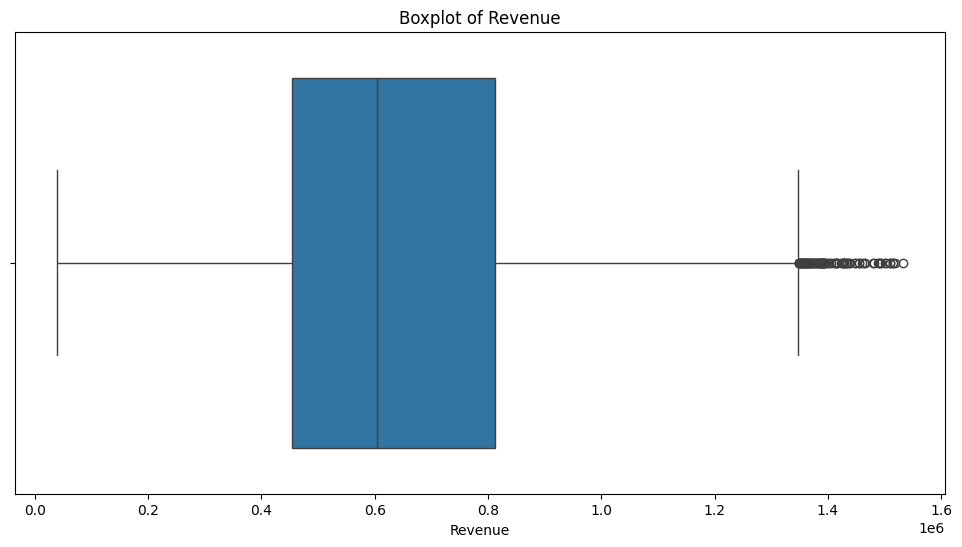

number of outliers detected:30


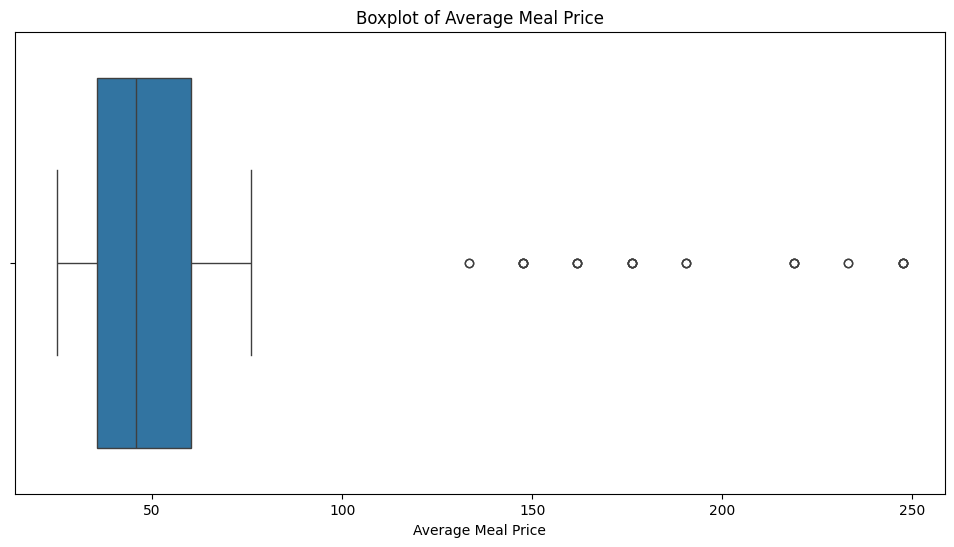

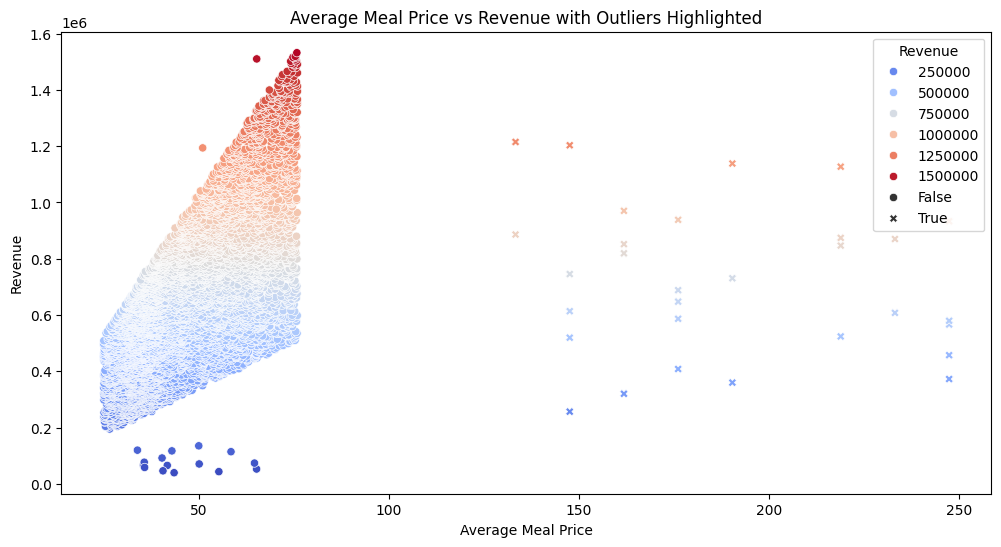

number of outliers detected:0


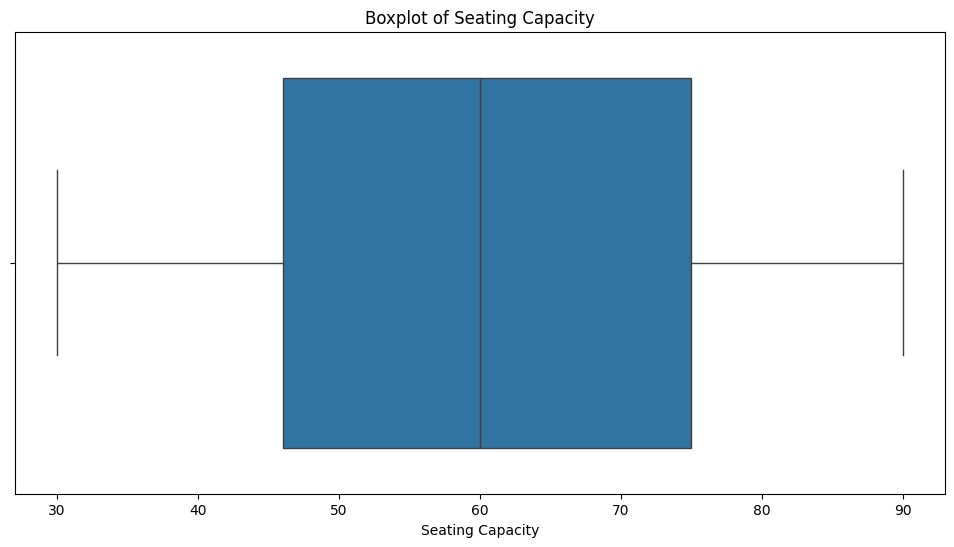

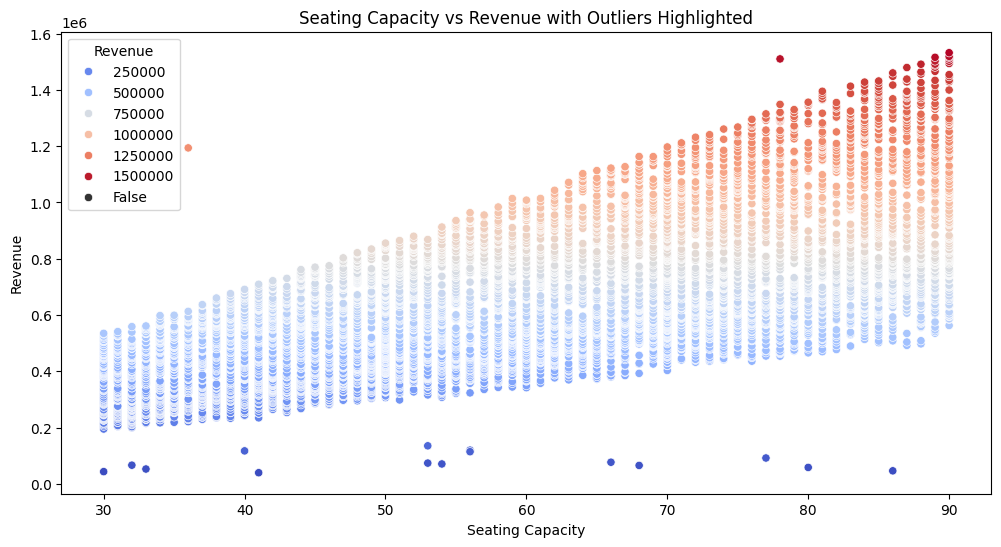

number of outliers detected:293


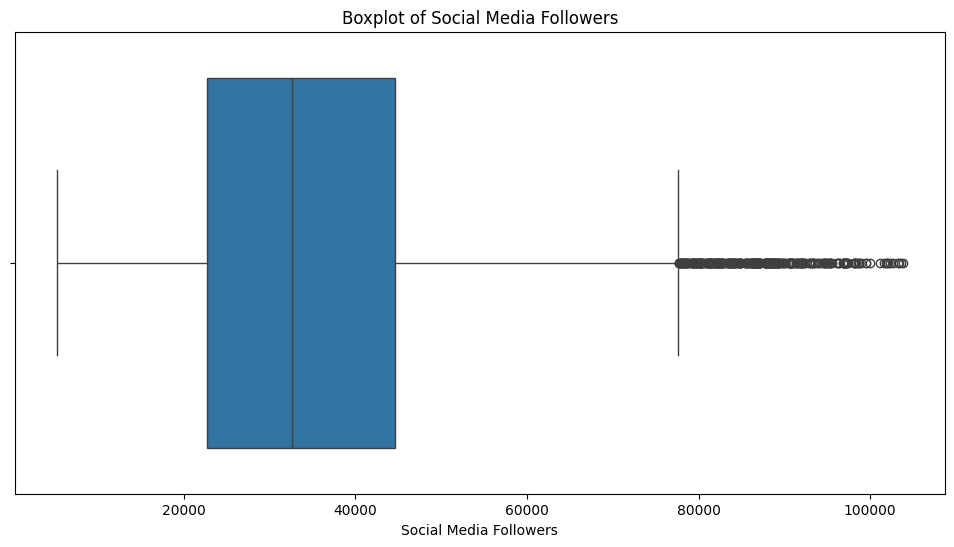

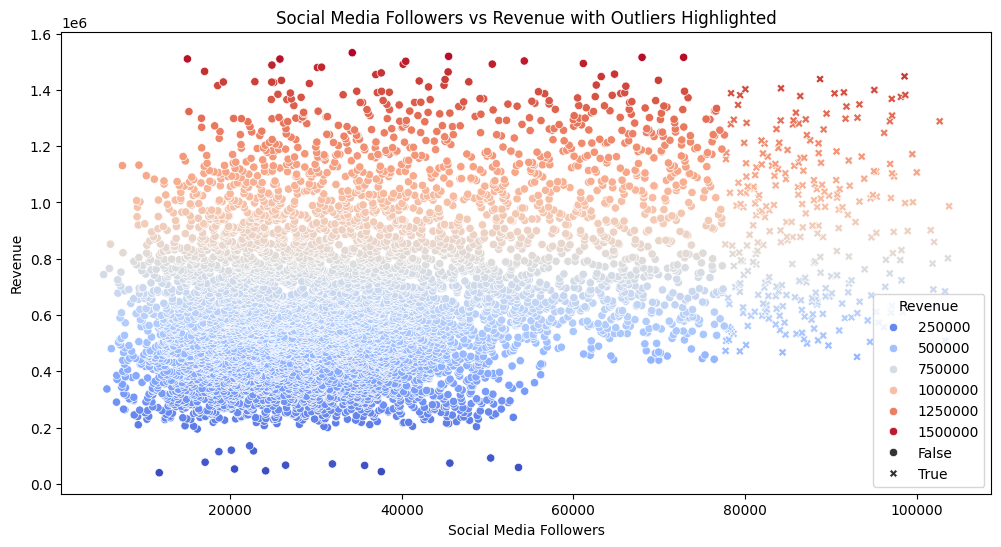

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cols = ['Revenue', 'Average Meal Price', 'Seating Capacity', 'Social Media Followers']

for col in cols:
    # Identify outliers in 'Marketing Budget'
    outlier_indices = find_outliers_iqr(df[col])
    outlier_mask = df.index.isin(outlier_indices)
    
    # Visualization of 'Marketing Budget' and 'Social Media Followers'
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=col, data=df)
    plt.title(f'Boxplot of {col}')
    plt.show()
    
    # Scatter plots to visualize outliers in relation to Revenue
    if col != 'Revenue':
        plt.figure(figsize=(12, 6))
        sns.scatterplot(x=col, y='Revenue', data=df, hue='Revenue', palette='coolwarm', style=outlier_mask)
        plt.title(f'{col} vs Revenue with Outliers Highlighted')
        plt.show()


number of outliers detected:12


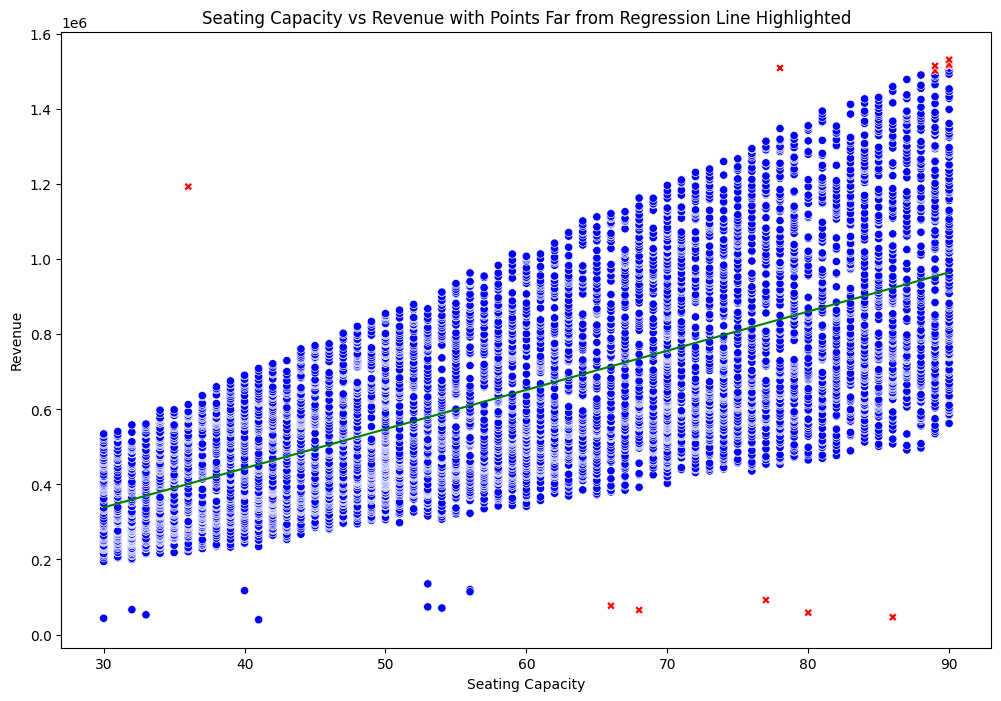

In [18]:
df['large_residuals'] = False
indices_large_residuals, linear_prediction = calculate_residuals(df, 'Seating Capacity', 'Revenue', 3.5)
df.loc[indices_large_residuals, 'large_residuals'] = True

# Visualization
plt.figure(figsize=(12, 8))
# Plotting all points
sns.scatterplot(x='Seating Capacity', y='Revenue', data=df, style='large_residuals', 
                hue='large_residuals', palette={False: 'blue', True: 'red'}, legend=None)
# Plotting regression line
plt.plot(df['Seating Capacity'], linear_prediction, color='green')
# # Highlighting points with large residuals
# large_resid_indices = df[df['large_residuals']].index
# sns.scatterplot(df.loc[large_resid_indices, 'Seating Capacity'], df.loc[large_resid_indices, 'Revenue'], 
#             color='red', s=50, edgecolor='k', label='High Residuals')
# plt.legend()

plt.title('Seating Capacity vs Revenue with Points Far from Regression Line Highlighted')
plt.xlabel('Seating Capacity')
plt.ylabel('Revenue')
plt.show()

number of outliers detected:15


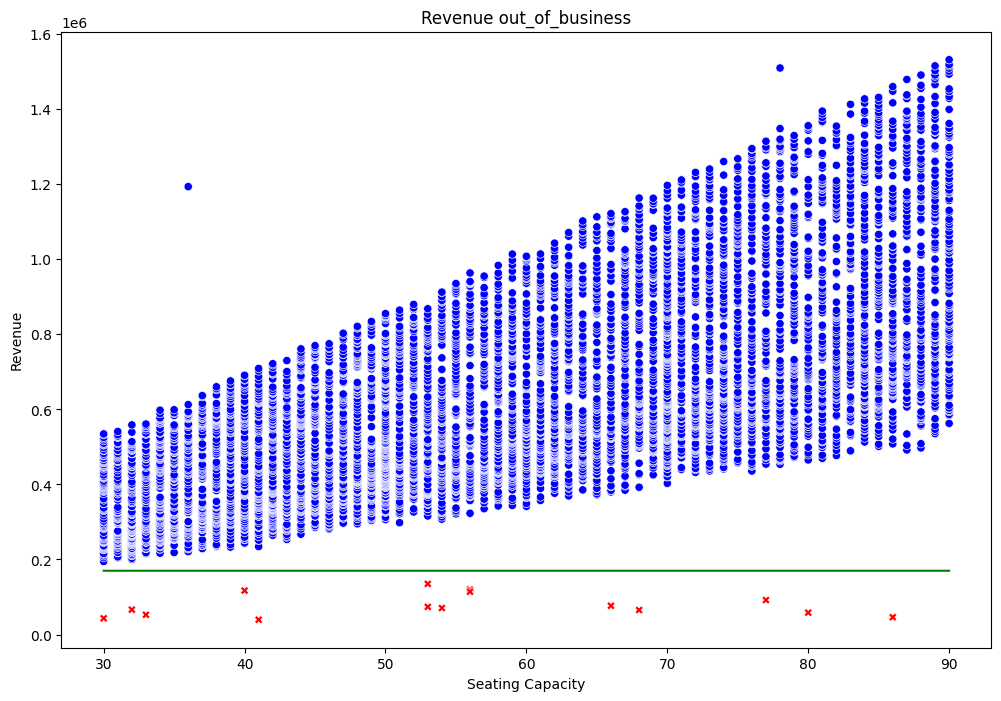

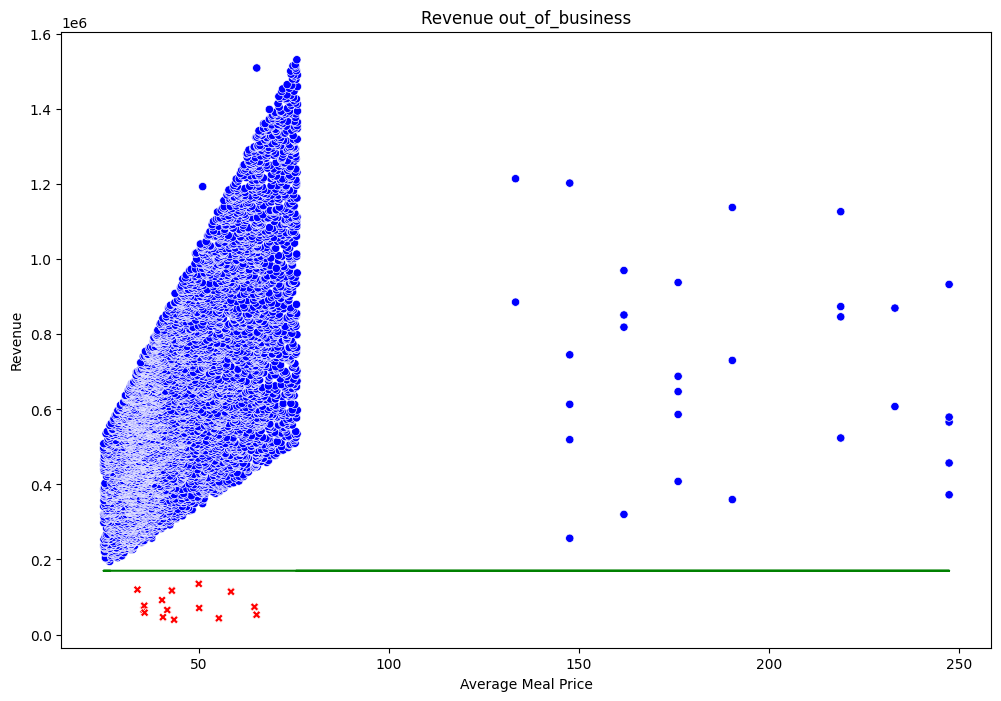

In [19]:
# Identify points with large residuals (e.g., more than 2 standard deviations away from the mean)
ind_out_of_business, out_of_business = calculate_out_out_of_business(df)
df['out_of_business'] = False

# Set True where indices match those identified as out of business
df.loc[ind_out_of_business, 'out_of_business'] = True

# Visualization
plt.figure(figsize=(12, 8))
# Plotting all points
sns.scatterplot(x='Seating Capacity', y='Revenue', data=df, style='out_of_business', 
                hue='out_of_business', palette={False: 'blue', True: 'red'}, legend=None)
# Plotting regression line
plt.plot(df['Seating Capacity'],[out_of_business] * len(df), color='green')
# # Highlighting points with large residuals
# large_resid_indices = df[df['large_residuals']].index
# sns.scatterplot(df.loc[large_resid_indices, 'Seating Capacity'], df.loc[large_resid_indices, 'Revenue'], 
#             color='red', s=50, edgecolor='k', label='High Residuals')
# plt.legend()

plt.title('Revenue out_of_business')
plt.xlabel('Seating Capacity')
plt.ylabel('Revenue')
plt.show()

# Visualization
plt.figure(figsize=(12, 8))
# Plotting all points
sns.scatterplot(x='Average Meal Price', y='Revenue', data=df, style='out_of_business', 
                hue='out_of_business', palette={False: 'blue', True: 'red'}, legend=None)
# Plotting regression line
plt.plot(df['Average Meal Price'],[out_of_business] * len(df), color='green')
# # Highlighting points with large residuals

plt.title('Revenue out_of_business')
plt.xlabel('Average Meal Price')
plt.ylabel('Revenue')
plt.show()

## Data Cleaning - handling outliers

In [20]:
df_train = df_train[['Seating Capacity', 'Average Meal Price', 'Social Media Followers', 'Revenue']].reset_index(drop=True)

In [21]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

def train_and_evaluate(X_train, y_train, X_test, y_test):
    lr = RandomForestRegressor(random_state=11)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae



# Assuming df_train and df_test are already defined
X_test, y_test = df_test.drop('Revenue', axis=1), df_test['Revenue']

# Original training data
X_train_orig, y_train_orig = df_train.drop('Revenue', axis=1), df_train['Revenue']
mae_original = train_and_evaluate(X_train_orig, y_train_orig, X_test, y_test)
print(f"Original MAE: {mae_original}")

# Step 1: Remove outliers based on 'Average Meal Price'
outlier_indices = find_outliers_iqr(df_train['Average Meal Price'])
df_train_filtered = df_train.drop(index=outlier_indices).reset_index(drop=True)
X_train, y_train = df_train_filtered.drop('Revenue', axis=1), df_train_filtered['Revenue']
mae_step1 = train_and_evaluate(X_train, y_train, X_test, y_test)
print(f"MAE after removing 'Average Meal Price' outliers: {mae_step1}")

# Step 2: Remove rows with high residuals from 'Seating Capacity'
residual_indices, _ = calculate_residuals(df_train_filtered, 'Seating Capacity', 'Revenue', 3)
df_train_filtered = df_train_filtered.drop(index=residual_indices).reset_index(drop=True)
X_train, y_train = df_train_filtered.drop('Revenue', axis=1), df_train_filtered['Revenue']
mae_step2 = train_and_evaluate(X_train, y_train, X_test, y_test)
print(f"MAE after removing high residuals: {mae_step2}")

# Step 3: Remove rows where revenue is below a certain threshold (considered as out of business)
outlier_indices, _ = calculate_out_out_of_business(df_train_filtered)
df_train_filtered = df_train_filtered.drop(index=outlier_indices).reset_index(drop=True)
X_train, y_train = df_train_filtered.drop('Revenue', axis=1), df_train_filtered['Revenue']
mae_step3 = train_and_evaluate(X_train, y_train, X_test, y_test)
print(f"MAE after removing 'out of business' records: {mae_step3}")


Original MAE: 7415.4342588386335
number of outliers detected:30
MAE after removing 'Average Meal Price' outliers: 7276.081897223887
number of outliers detected:50
MAE after removing high residuals: 6709.231587053124
number of outliers detected:7
MAE after removing 'out of business' records: 6402.374331822913
